## Impoting Libraries auch as Pandas,numpy,datetime,yfinance

In [3]:
import pandas as pd
!pip install pandas_datareader
import pandas_datareader as pdr
from datetime import datetime
import yfinance as yf
import numpy as np

   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ---------------------------- ----------- 2.9/4.0 MB 14.4 MB/s eta 0:00:01
   ---------------------------------------- 4.0/4.0 MB 11.6 MB/s  0:00:00

   ---------------------------------------- 0/2 [lxml]
   ---------------------------------------- 0/2 [lxml]
   ---------------------------------------- 0/2 [lxml]
   ---------------------------------------- 0/2 [lxml]
   ---------------------------------------- 0/2 [lxml]
   ---------------------------------------- 0/2 [lxml]
   -------------------- ------------------- 1/2 [pandas_datareader]
   -------------------- ------------------- 1/2 [pandas_datareader]
   -------------------- ------------------- 1/2 [pandas_datareader]
   -------------------- ------------------- 1/2 [pandas_datareader]
   -------------------- ------------------- 1/2 [pandas_datareader]
   -------------------- ------------------- 1/2 [pandas_datareader]
   -------------------- -----------------

Downloading the 5 year Dataset of Apple and Microsoft Stocks

In [6]:
stocks=["AAPL", "MSFT"]
data = yf.download(stocks, start="2019-01-01", end="2026-01-15")['Close']


[*********************100%***********************]  2 of 2 completed


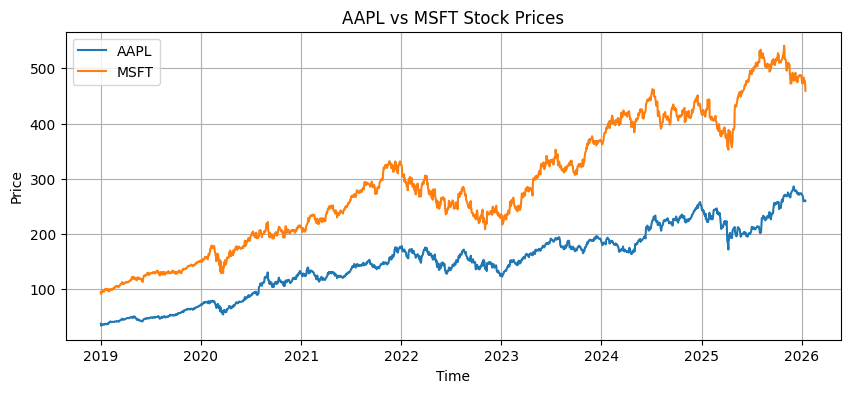

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
apple = data['AAPL']
microsoft = data['MSFT']

plt.plot(apple, label="AAPL")
plt.plot(microsoft, label="MSFT")
plt.legend()
plt.title("AAPL vs MSFT Stock Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Spread between APPL and MSFT')

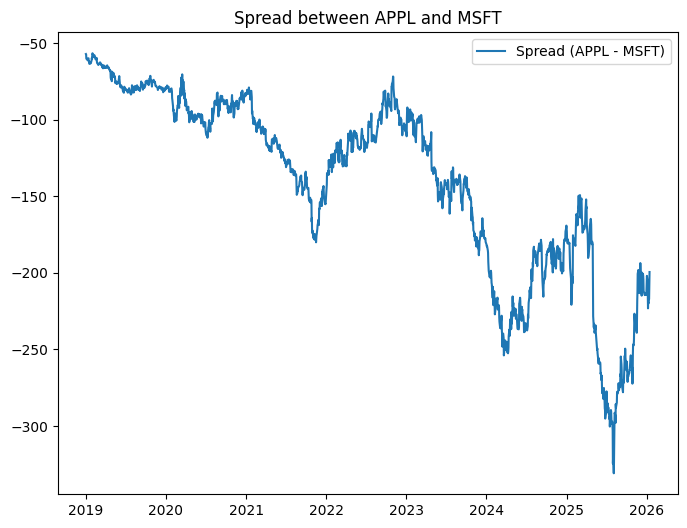

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(apple - microsoft, label = 'Spread (APPL - MSFT)')
plt.legend()
plt.title("Spread between APPL and MSFT")

In [18]:
"""
Cointegration Test Using Engle–Granger Method

This code tests whether two time series (apple and microsoft prices)
are cointegrated, meaning they share a long-run equilibrium relationship.

Steps:
1. The Engle–Granger cointegration test is applied using statsmodels.
2. The test estimates a linear combination of the two series and checks
   whether the residuals are stationary.
3. The function ts.coint() returns:
   - Test statistic (cointegration t-statistic)
   - p-value
   - Critical values at 1%, 5%, and 10% significance levels

Interpretation:
- Null hypothesis (H0): The series are NOT cointegrated.
- If p-value < 0.05, we reject H0 and conclude the series are cointegrated.
- Cointegration implies the price spread is mean-reverting, which is a
   necessary condition for pair trading strategies.

This test validates whether apple and microsoft can be used as a
statistical arbitrage pair.
"""

!pip install statsmodels
import statsmodels.tsa.stattools as ts
result = ts.coint(apple, microsoft)
cointegration_t_statistic = result[0]
p_val = result[1]
critical_values_test_statistic_at_1_5_10 = result[2]
print('P value for cointegration test is', p_val)

P value for cointegration test is 0.32608004858059564


Text(0.5, 1.0, 'Price Ratio between apple and MSFT')

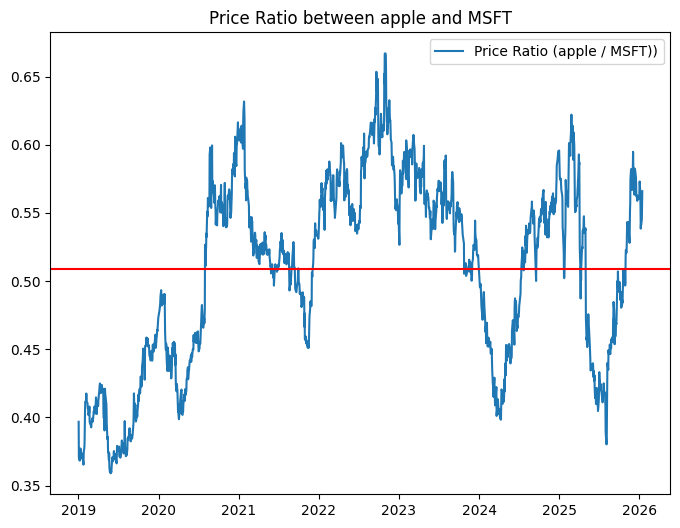

In [13]:
plt.figure(figsize=(8, 6))
ratio = apple / microsoft
plt.plot(ratio, label = 'Price Ratio (apple / MSFT))')
plt.axhline(ratio.mean(), color='red')
plt.legend()
plt.title("Price Ratio between apple and MSFT")


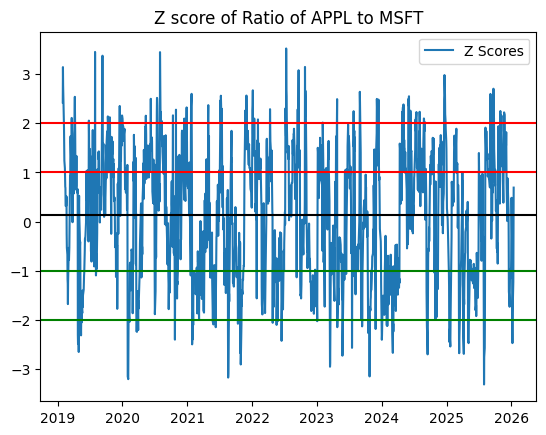

In [14]:
zscore = (ratio - ratio.rolling(window=20).mean()) / ratio.rolling(window=20).std()
plt.plot(zscore, label = "Z Scores")
plt.axhline(zscore.mean(), color = 'black')
plt.axhline(1.0, color='red')
plt.axhline(2, color='red')
plt.axhline(-1.0, color='green')
plt.axhline(-2, color='green')
plt.legend(loc = 'best')
plt.title('Z score of Ratio of APPL to MSFT')
plt.show()

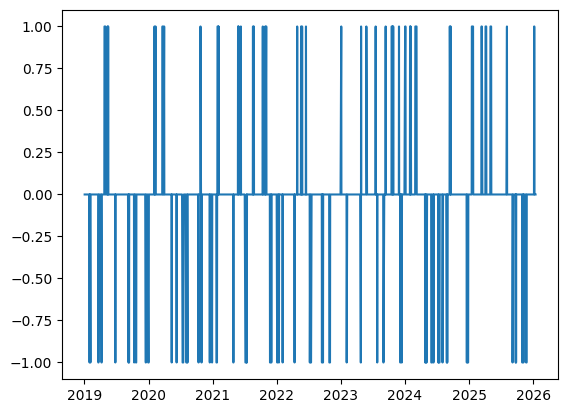

In [15]:
#for rolling mean window number of days.
lookback = 20
threshold_entry = 2
threshold_exit = 2

data['ratio'] = data['AAPL'] / data['MSFT']

#for rolling mean and standard mean calculation for zscore.

data['rolling_mean'] = data['ratio'].rolling(window=lookback).mean()
data['rolling_std'] = data['ratio'].rolling(window=lookback).std()

# z-score.
data['zscore'] = (data['ratio'] - data['rolling_mean']) / data['rolling_std']

# Generating signals based on z score for each day.
data['signal'] = 0
data.loc[data['zscore'] < -threshold_entry, 'signal'] = 1   # Buy signal
data.loc[data['zscore'] > threshold_exit, 'signal'] = -1   # Sell signal

#added parameter for stoploss for +-2.7.
stop_loss= 2.7
data['signal'] = np.where(abs(data['zscore']) > stop_loss, 0, data['signal'])

# exit using flattening signal to 0.
data.loc[(data['zscore'] > -threshold_exit) & (data['zscore'] < threshold_exit), 'signal'] = 0
data['signal']
plt.plot(data['signal'])

In [19]:
"""
Backtesting and Performance Evaluation (Pair Trading Strategy)

This code block backtests a market-neutral pair trading strategy and
computes key performance metrics.

Backtesting Logic:
1. Daily returns are calculated for AAPL and MSFT using percentage change.
2. Strategy returns are computed as:
   strat_returns = previous_day_signal * (AAPL_return - MSFT_return)
   This reflects a long-short position where:
   - signal =  1 → long AAPL, short MSFT
   - signal = -1 → short AAPL, long MSFT
3. The signal is shifted by one day to avoid look-ahead bias.
4. Cumulative returns are calculated using compound growth:
   cumulative_returns = cumulative product of (1 + strat_returns)

Performance Metrics:
- Total Return:
  Final cumulative return minus 1.

- Annualized Return:
  Scales total return to a yearly basis assuming 252 trading days:
  annualized_return = (final_cumulative_return)^(1 / years) - 1

- Annualized Volatility:
  Standard deviation of daily strategy returns scaled by sqrt(252).

- Sharpe Ratio:
  Risk-adjusted return assuming zero risk-free rate:
  sharpe_ratio = annualized_return / annualized_volatility

- Max Drawdown:
  Maximum peak-to-trough loss, calculated using cumulative returns.

- Win Rate:
  Fraction of profitable strategy-return days when a position was active.

Purpose:
This evaluation framework measures profitability, risk, and consistency
of the pair trading strategy, allowing comparison with other strategies
on a risk-adjusted basis.
"""

import numpy as np
data['AAPL_daily_returns'] = data['AAPL'].pct_change()
data['MSFT_daily_returns'] = data['MSFT'].pct_change()
data['strat_returns']=data['signal'].shift(1) * (data['AAPL_daily_returns'] - data['MSFT_daily_returns'])
data['cumulative_returns'] = (1 + data['strat_returns']).cumprod()

#performance metrics
total_return = data['cumulative_returns'].iloc[-1] - 1

years = len(data) / 252  # Trading days per year

annualized_return = (data['cumulative_returns'].iloc[-1] ** (1/years)) - 1
annualized_vol = data['strat_returns'].std() * np.sqrt(252)

#calculatig sharpe while considering zero risk free rate
sharpe_ratio = (annualized_return ) / annualized_vol

#max
cumulative_max = data['cumulative_returns'].cummax()
drawdown = (data['cumulative_returns'] - cumulative_max) / cumulative_max
max_drawdown = drawdown.min()
winning_trades = data[data['strat_returns'] > 0]
win_rate = len(winning_trades) / len(data[data['signal'].shift(1) != 0])

results = {
    "Total Return": total_return,
    "Annualized Return": annualized_return,
    "Annualized Volatility": annualized_vol,
    "Sharpe Ratio": sharpe_ratio,
    "Max Drawdown": max_drawdown,
    "Win Rate": win_rate,
}

pd.DataFrame(results, index=["Performance"])

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Win Rate
Performance,0.239998,0.031117,0.084039,0.370272,-0.218786,0.505682


                       Performance
Total Return              0.239998
Annualized Return         0.031117
Annualized Volatility     0.084039
Sharpe Ratio              0.370272
Max Drawdown             -0.218786
Win Rate                  0.505682


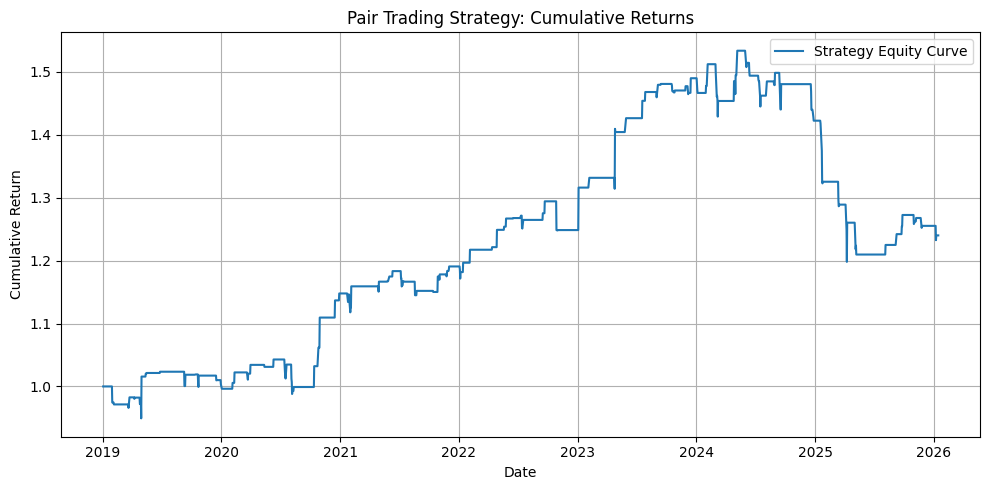

In [20]:

# Display results
performance_df = pd.DataFrame(results, index=["Performance"]).T
print(performance_df)

# Optional: Plot equity curve
plt.figure(figsize=(10, 5))
plt.plot(data['cumulative_returns'], label='Strategy Equity Curve')
plt.title('Pair Trading Strategy: Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
